<a href="https://colab.research.google.com/github/njcoburn/MEMS_SWITCH/blob/main/Working_MEMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

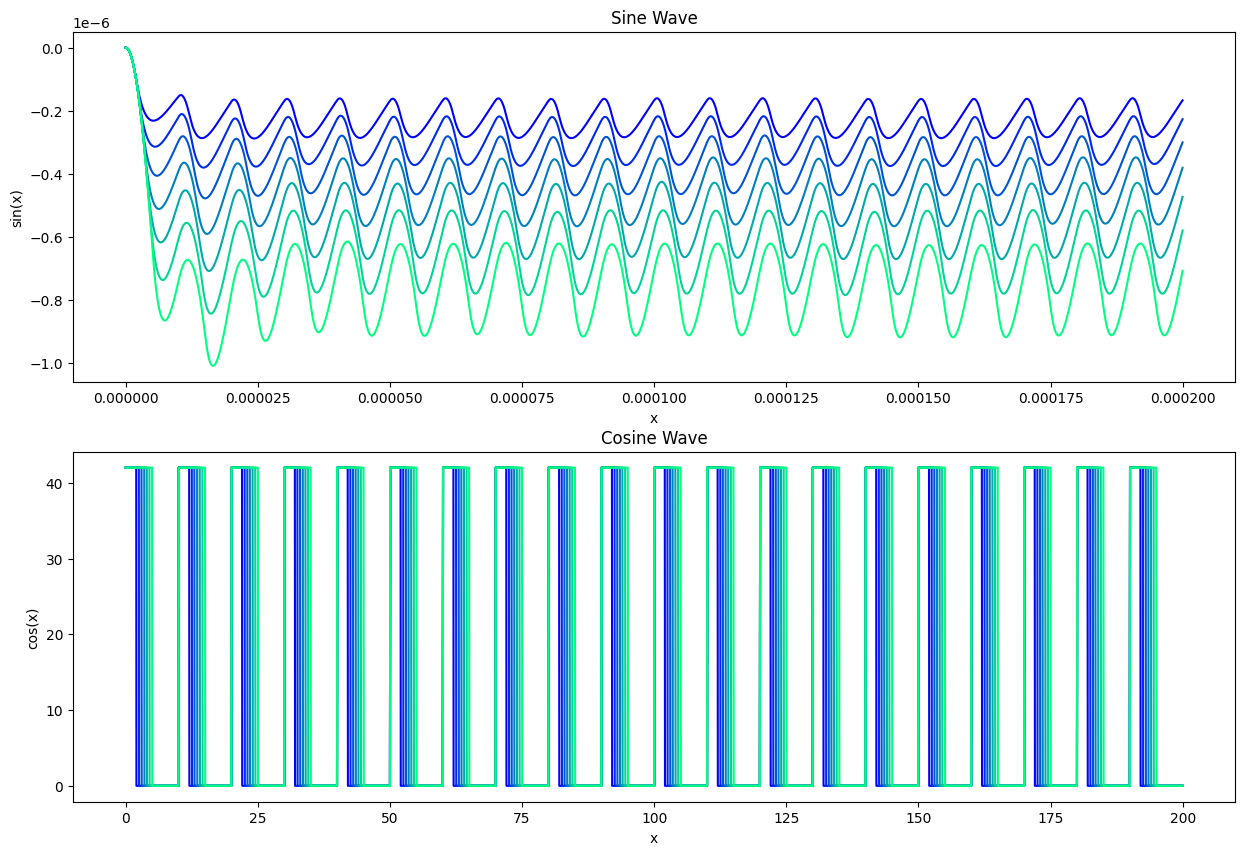

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import pi, sqrt

e0=8.85418782e-12
V=42
go = 3e-6
E=78e9 #Au
l = 300e-6
t = 0.8e-6
w = 100e-6
I=(w*(t)**3)/12
k2=3*E*I/(l**3)
k = 10 #k2 #10.0  # spring constant, N/m
m = 0.35*(w)*(l)*(t)*(19320) # mass, Kg
freq = 39.5e3 # change to (k/m)**0.5
C1 = 1e-80
C2 = 1e-75
A = w**2 #w*l*0.75
td=150e-9
er=7.6
y = 0.06e-6  # lambda

F = 55e-6 #restoring force???

time_list_empty = []
z_empty = []


fig, axs = plt.subplots(2, figsize=(15, 10))  # 2 subplots vertically

percent_list = [20, 25, 30, 35, 40, 45, 50]
color_idx = np.linspace(0, 1, len(percent_list))
for j, y in zip (color_idx, percent_list):
  time_list = []
  z = []
  state0_list = [[0,0]]

  percent = y
  TimePeriod = 10e-6
  Cycles = 20  # Single cycle
  dt = 10000
  Amplitude = 42

  t = np.linspace(0, Cycles*TimePeriod, dt, endpoint=False)
  pwm = (t % TimePeriod < TimePeriod * percent / 100) * Amplitude

  # Define your functions for high and low states
  def process_segment(state, start, end):
      if state == 'High':
          # Example operation for high state
          #return f"High segment processed from {start:.8f} to {end:.8f} seconds"
          ###DOWN - VOLTAGE ON
          def rlc(state_yes,t_segment,Q):
              x, xd = state_yes
              g = x+go
              Fe = ((e0*A*(V**2))/((go+(td/er)+x)**2))*-0.5 #voltageSource
              Fc = ((C1*A)/(go+x)**3) - ((C2*A)/(go+x)**10)
              Qe = Q*((1.1-((x/go)**2))**(1.5))*(1+(9.638*((y/g)**1.159)))
              b = k/(2*pi*freq*Qe)   # damping coefficient - variable damping
              #b = k/(2*pi*freq*Q) # damping coefficient - constant damping
              ks = (55e-6-k*go)/(go**3)
              #F = k*(go-x) + ks*(go-x)**3
              xdd = (Fe+Fc-(b*xd)-(k*x)-(ks*(x**3)))/m
              return [xd, xdd]

          state0 = state0_list[-1]  #initial conditions [x0 , v0]  [m, m/sec]

          ti = start
          tf = end  # final time
          res = 10000 # steps
          t_segment = np.linspace(ti, tf, res)
          Q=0.5
          state_yes = odeint(rlc, state0, t_segment, args=(Q,))
          x = np.array(state_yes[:,[0]])
          xd = np.array(state_yes[:,[1]])
          #print(t_segment[-1], x[-1], xd[-1])
          state0_list.append([x[-1][0], xd[-1][0]])
          for i in range(len(x)):
              x[i] += go
          index = np.argmin(abs(x))
          #fig ,ax1 = plt.subplots()
          #ax1.plot(t[0:(index+1)]*1e6,x[0:(index+1)]*1e6, 'b-',linewidth=3) #x and y plotted values multiplied by 1e6 to scale up for plotted units.

          for i in t_segment:
            time_list.append(i)
          for i in state_yes[:,0]:
            z.append(i)

      elif state == 'Low':
          # Example operation for low state
          #return f"Low segment processed from {start:.8f} to {end:.8f} seconds"
          ###UP - VOLTAGE OFF

          def rlc(state_no,t_sement,Q):
              x, xd = state_no
              g =  go - x
              Qe = Q*((1.1-((x/go)**2))**(1.5))*(1+9.638*((y/g)**1.159))
              #b = k/(2*pi*freq*Qe)   # damping coefficient - variable damping
              b = k/(2*pi*freq*Q) # damping coefficient - constant damping
              ks = (F-k*go)/(go**3)
              Fc = ((C1*A)/(go-x)**3) - ((C2*A)/(go-x)**10)
              #F = k*(go-x) + ks*(go-x)**3
              xdd = (Fc-(b*xd)-k*x-ks*(x**3))/m
              return [xd, xdd]

          state0 = state0_list[-1] #[-1.85148446e-06, -0.39846986]   #initial conditions [x0 , v0]  [m, m/sec]

          ti = start
          tf = end  # final time
          res = 10000 # steps
          t_segment = np.linspace(ti, tf, res)

          Q=0.5

          state_no = odeint(rlc, state0, t_segment, args=(Q,))

          x = np.array(state_no[:,[0]])
          xd = np.array(state_no[:,[1]])

          #print(t_segment[-1], x[-1], xd[-1])
          state0_list.append([x[-1][0], xd[-1][0]])
          for i in range(len(x)):
              x[i] += go

          index = np.argmin(abs(x))

          #fig ,ax1 = plt.subplots()

          #ax1.plot(t1*1e6,x*1e6, 'r-',linewidth=3, label='$Q = 0.5$')
          #ax1.plot(t*1e6,x*1e6, 'b-',linewidth=3) #x and y plotted values multiplied by 1e6 to scale up for plotted units.

          #ax1.set_xlabel('time ($\mu$s)')
          #ax1.set_ylabel('Gap Height ($\mu$m)', )#color='g')

          for i in t_segment:
            time_list.append(i)
          for i in state_no[:,0]:
            z.append(i)



  # Initialize variables to store the start times for high and low states
  start_high = None
  start_low = None
  # Initialize lists to store start and end times for high and low states, including state information
  segments = []

  # Handle the initial state
  if pwm[0] > 0:
      start_high = t[0]
  else:
      start_low = t[0]

  # Identify segments
  for i in range(1, len(pwm)):
      if pwm[i] != pwm[i-1]:  # State change
          if pwm[i] > 0:  # Transition to high
              start_high = t[i]
              if start_low is not None:
                  end_low = t[i-1]
                  segments.append(('Low', start_low, end_low))
                  start_low = None
          else:  # Transition from high to low
              end_high = t[i-1]
              if start_high is not None:
                  segments.append(('High', start_high, end_high))
                  start_high = None
              start_low = t[i]

  # Ensure the last segment is captured
  if start_high is not None:
      segments.append(('High', start_high, t[-1]))
  elif start_low is not None:
      segments.append(('Low', start_low, t[-1]))

  # Sort segments by their start time
  segments.sort(key=lambda x: x[1])

  # Process each segment in order
  for segment in segments:
      state, start, end = segment
      process_segment(state, start, end)

  time_list_empty.append(time_list)
  z_empty.append(z)
  # Plot the original signal for reference
  col=plt.cm.winter(j)

  # Create a figure and a set of subplots


  # Plotting on the first subplot
  axs[0].plot(time_list, z, color=col)  # 'b' specifies the color blue
  axs[0].set_title('Sine Wave')
  axs[0].set_xlabel('x')
  axs[0].set_ylabel('sin(x)')

  # Plotting on the second subplot
  axs[1].plot(t*1e6, pwm, color=col)  # 'r' specifies the color red
  axs[1].set_title('Cosine Wave')
  axs[1].set_xlabel('x')
  axs[1].set_ylabel('cos(x)')

  '''
  plt.figure(1, figsize=(10, 4))
  #plt.plot(t, pwm)
  plt.plot(time_list,z, color=col)
  plt.title('Original Signal')
  #plt.show()
  '''
plt.show()

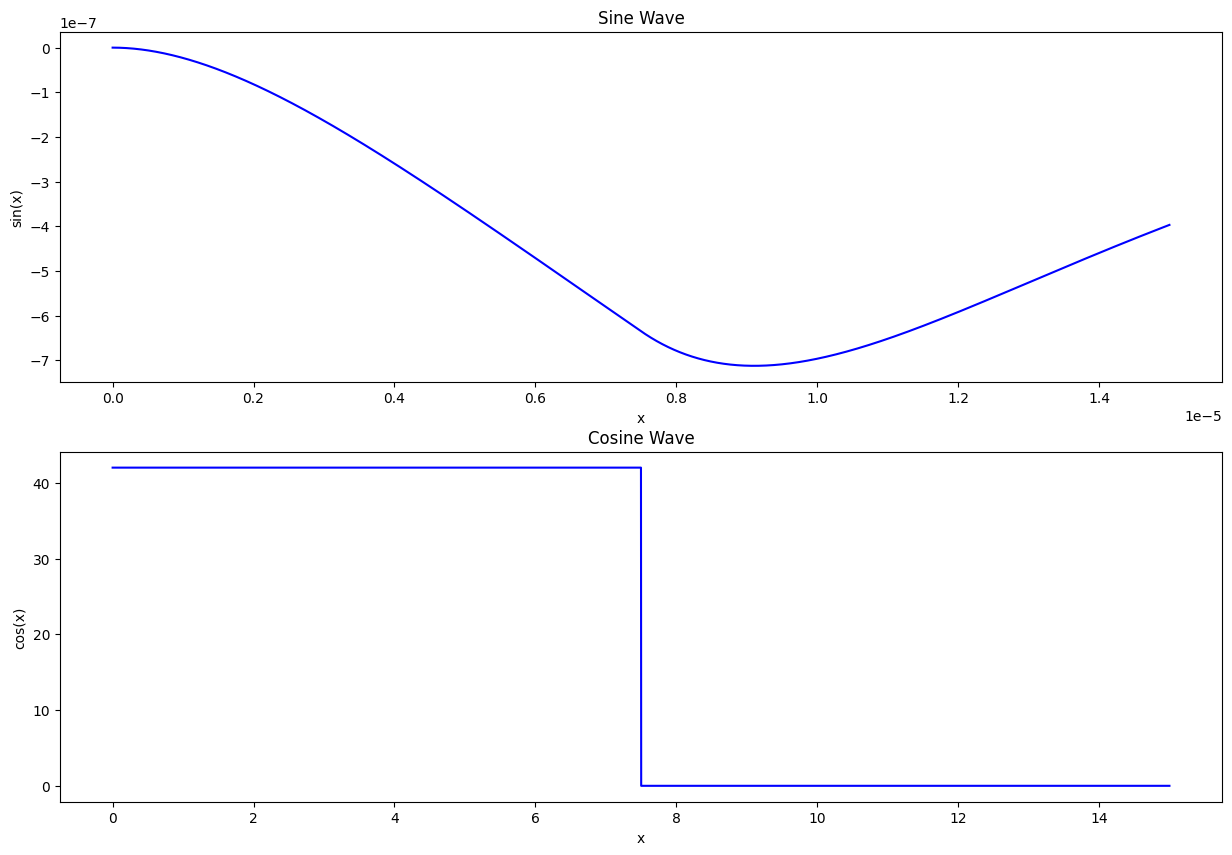

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import pi, sqrt

e0=8.85418782e-12
V=42
go = 3e-6
E=78e9 #Au
l = 300e-6
t = 0.8e-6
w = 100e-6
I=(w*(t)**3)/12
k2=3*E*I/(l**3)
k = 10 #k2 #10.0  # spring constant, N/m
m = 0.35*(w)*(l)*(t)*(19320) # mass, Kg
freq = 39.5e3 # change to (k/m)**0.5
C1 = 1e-80
C2 = 1e-75
A = w**2 #w*l*0.75
td=150e-9
er=7.6
y = 0.06e-6  # lambda

F = 55e-6 #restoring force???

time_list_empty = []
z_empty = []


fig, axs = plt.subplots(2, figsize=(15, 10))  # 2 subplots vertically

percent_list = [50]
color_idx = np.linspace(0, 1, len(percent_list))
for j, q in zip (color_idx, percent_list):
  time_list = []
  z = []
  state0_list = [[0,0]]

  percent = q
  TimePeriod = 15e-6
  Cycles = 1  # Single cycle
  dt = 10000
  Amplitude = 42

  t = np.linspace(0, Cycles*TimePeriod, dt, endpoint=False)
  pwm = (t % TimePeriod < TimePeriod * percent / 100) * Amplitude

  def process_segment(state, start, end):
      if state == 'High':
          def rlc(state_yes,t_segment,Q):
              x, xd = state_yes
              g = x+go
              Fe = ((e0*A*(V**2))/((go+(td/er)+x)**2))*-0.5 #voltageSource
              Fc = ((C1*A)/(go+x)**3) - ((C2*A)/(go+x)**10)
              Qe = Q*((1.1-((x/go)**2))**(1.5))*(1+(9.638*((y/g)**1.159)))
              b = k/(2*pi*freq*Qe)   # damping coefficient - variable damping
              #b = k/(2*pi*freq*Q) # damping coefficient - constant damping
              ks = (55e-6-k*go)/(go**3)
              #F = k*(go-x) + ks*(go-x)**3
              xdd = (Fe+Fc-(b*xd)-(k*x)-(ks*(x**3)))/m
              return [xd, xdd]

          state0 = state0_list[-1]  #initial conditions [x0 , v0]  [m, m/sec]
          ti = start
          tf = end  # final time
          res = 10000 # steps
          t_segment = np.linspace(ti, tf, res)
          Q=0.5
          state_yes = odeint(rlc, state0, t_segment, args=(Q,))
          x = np.array(state_yes[:,[0]])
          xd = np.array(state_yes[:,[1]])
          #print(t_segment[-1], x[-1], xd[-1])
          state0_list.append([x[-1][0], xd[-1][0]])
          for i in range(len(x)):
              x[i] += go
          index = np.argmin(abs(x))
          for i in t_segment:
            time_list.append(i)
          for i in state_yes[:,0]:
            z.append(i)

      elif state == 'Low':
          def rlc(state_no,t_segment,Q):
              x, xd = state_no
              g =  go - x
              Qe = Q*((1.1-((x/go)**2))**(1.5))*(1+9.638*((y/g)**1.159))
              #b = k/(2*pi*freq*Qe)   # damping coefficient - variable damping
              b = k/(2*pi*freq*Q) # damping coefficient - constant damping
              ks = (F-k*go)/(go**3)
              Fc = ((C1*A)/(go-x)**3) - ((C2*A)/(go-x)**10)
              #F = k*(go-x) + ks*(go-x)**3
              xdd = (Fc-(b*xd)-k*x-ks*(x**3))/m
              return [xd, xdd]

          state0 = state0_list[-1] #[-1.85148446e-06, -0.39846986]   #initial conditions [x0 , v0]  [m, m/sec]
          ti = start
          tf = end  # final time
          res = 10000 # steps
          t_segment = np.linspace(ti, tf, res)
          Q=0.5
          state_no = odeint(rlc, state0, t_segment, args=(Q,))
          x = np.array(state_no[:,[0]])
          xd = np.array(state_no[:,[1]])
          state0_list.append([x[-1][0], xd[-1][0]])
          for i in range(len(x)):
              x[i] += go
          index = np.argmin(abs(x))

          for i in t_segment:
            time_list.append(i)
          for i in state_no[:,0]:
            z.append(i)

  # Initialize variables to store the start times for high and low states
  start_high = None
  start_low = None
  # Initialize lists to store start and end times for high and low states, including state information
  segments = []

  # Handle the initial state
  if pwm[0] > 0:
      start_high = t[0]
  else:
      start_low = t[0]

  # Identify segments
  for i in range(1, len(pwm)):
      if pwm[i] != pwm[i-1]:  # State change
          if pwm[i] > 0:  # Transition to high
              start_high = t[i]
              if start_low is not None:
                  end_low = t[i-1]
                  segments.append(('Low', start_low, end_low))
                  start_low = None
          else:  # Transition from high to low
              end_high = t[i-1]
              if start_high is not None:
                  segments.append(('High', start_high, end_high))
                  start_high = None
              start_low = t[i]

  # Ensure the last segment is captured
  if start_high is not None:
      segments.append(('High', start_high, t[-1]))
  elif start_low is not None:
      segments.append(('Low', start_low, t[-1]))

  # Sort segments by their start time
  segments.sort(key=lambda x: x[1])

  # Process each segment in order
  for segment in segments:
      state, start, end = segment
      process_segment(state, start, end)

  time_list_empty.append(time_list)
  z_empty.append(z)
  # Plot the original signal for reference
  col=plt.cm.winter(j)
  axs[0].plot(time_list, z, color=col)  # 'b' specifies the color blue
  axs[0].set_title('Sine Wave')
  axs[0].set_xlabel('x')
  axs[0].set_ylabel('sin(x)')
  axs[1].plot(t*1e6, pwm, color=col)  # 'r' specifies the color red
  axs[1].set_title('Cosine Wave')
  axs[1].set_xlabel('x')
  axs[1].set_ylabel('cos(x)')
plt.show()

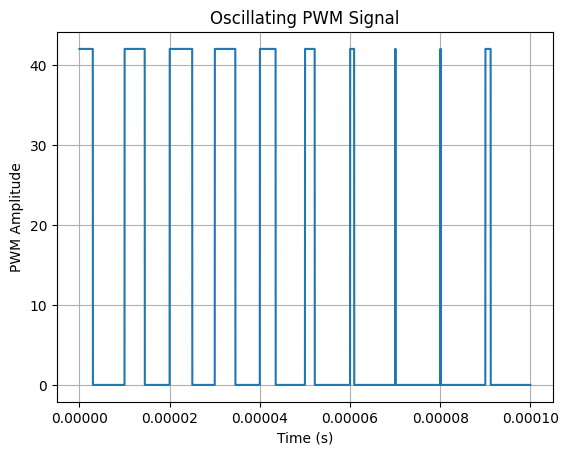

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
percent = 50  # Maximum percent
TimePeriod = 10e-6
Cycles = 10  # Number of cycles
dt = 10000
Amplitude = 42

# Time array
t = np.linspace(0, Cycles * TimePeriod, dt, endpoint=False)

# Calculate the varying duty cycle over time using a sinusoidal function
oscillating_percent = (np.sin(2 * np.pi * t / (Cycles * TimePeriod)) + 1) / 2 * percent

# Calculate the PWM signal
pwm = (t % TimePeriod < TimePeriod * oscillating_percent / 100) * Amplitude

# Plotting
plt.plot(t, pwm)
plt.title('Oscillating PWM Signal')
plt.xlabel('Time (s)')
plt.ylabel('PWM Amplitude')
plt.grid(True)
plt.show()


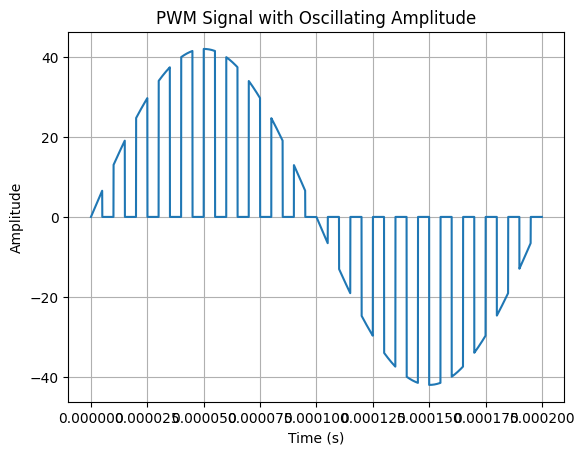

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
y = 50  # Fixed percent duty cycle
TimePeriod = 10e-6
Cycles = 20  # Number of cycles
dt = 10000
MaxAmplitude = 42

# Time array
t = np.linspace(0, Cycles * TimePeriod, dt, endpoint=False)

# Calculate the oscillating amplitude over time using a sinusoidal function
oscillating_amplitude = np.sin(2 * np.pi * t / (Cycles * TimePeriod)) * MaxAmplitude

# Calculate the PWM signal
pwm = (t % TimePeriod < TimePeriod * y / 100) * oscillating_amplitude

# Plotting
plt.plot(t, pwm)
plt.title('PWM Signal with Oscillating Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


[ 0.  0.  0. ... 42. 42. 42.]
[array([0., 0., 0., ..., 0., 0., 0.])]


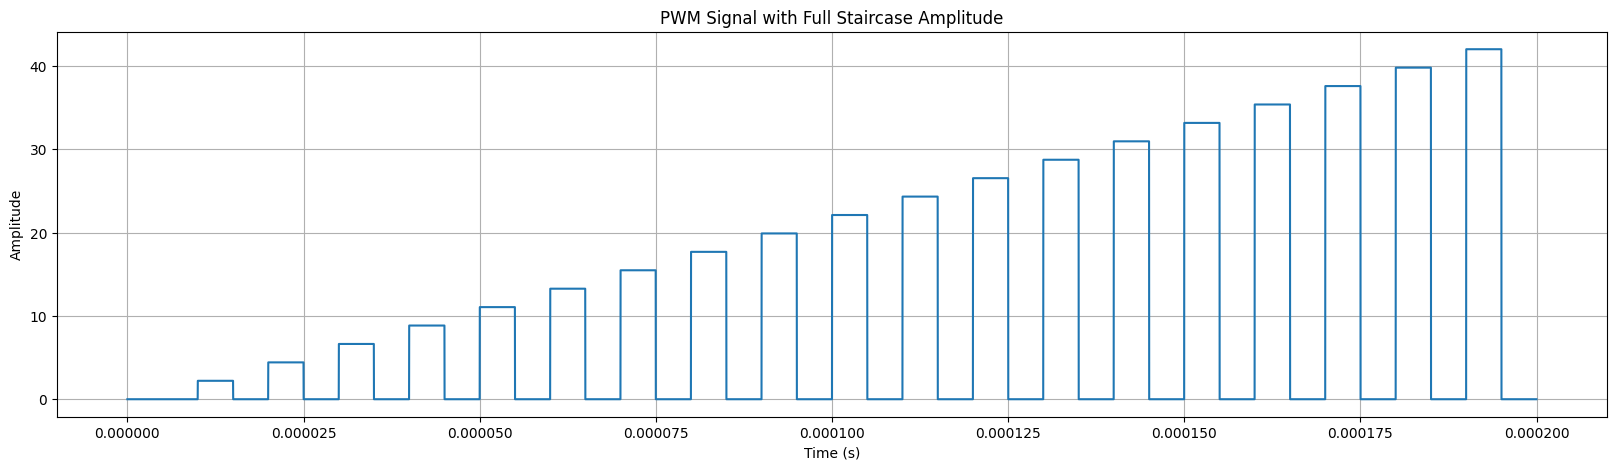

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
y = 50  # Fixed percent duty cycle
TimePeriod = 10e-6
Cycles = 20  # Number of cycles
dt = 10000
MaxAmplitude = 42
num_steps = 1 * Cycles  # Number of amplitude steps across all cycles

# Time array
t = np.linspace(0, Cycles * TimePeriod, dt, endpoint=False)

# Calculate the staircase amplitude over the entire duration
total_time = Cycles * TimePeriod
step_duration = total_time / num_steps
current_step = np.floor(t / step_duration)
oscillating_amplitude = (current_step / (num_steps - 1)) * MaxAmplitude

# Generate the PWM signal
pwm = (t % TimePeriod < TimePeriod * y / 100) * oscillating_amplitude

# Plotting
plt.figure(figsize=(20, 5))
plt.plot(t, pwm)
plt.title('PWM Signal with Full Staircase Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


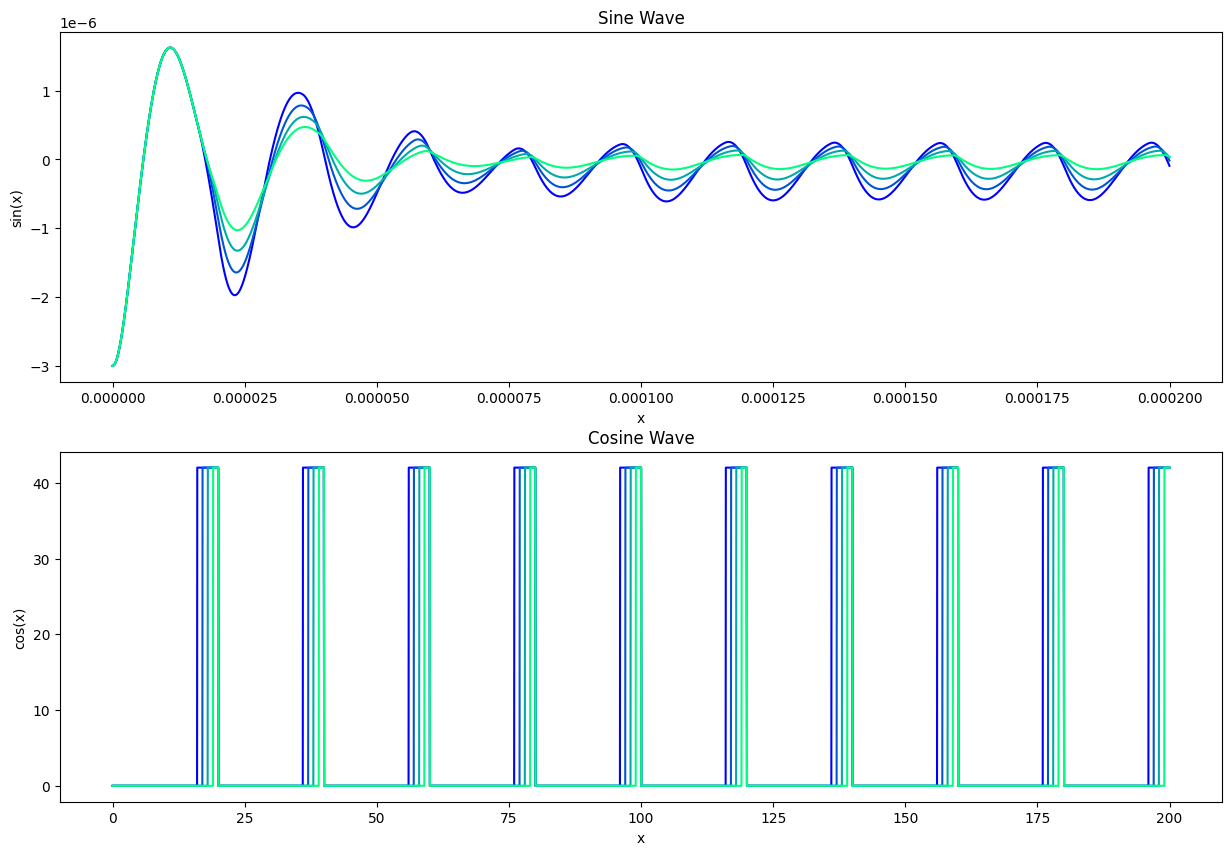

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import pi, sqrt

e0=8.85418782e-12
V=42
go = 3e-6
E=78e9 #Au
l = 300e-6
t = 0.8e-6
w = 100e-6
I=(w*(t)**3)/12
k2=3*E*I/(l**3)
k = 10 #k2 #10.0  # spring constant, N/m
m = 0.35*(w)*(l)*(t)*(19320) # mass, Kg
freq = 39.5e3 # change to (k/m)**0.5
C1 = 1e-80
C2 = 1e-75
A = w**2 #w*l*0.75
td=150e-9
er=7.6
y = 0.06e-6  # lambda

F = 55e-6 #restoring force???

time_list_empty = []
z_empty = []


fig, axs = plt.subplots(2, figsize=(15, 10))  # 2 subplots vertically

percent_list = [80, 85, 90, 95]#20, 25, 30, 35, 40, 45, 50]
color_idx = np.linspace(0, 1, len(percent_list))
for j, y in zip (color_idx, percent_list):
  time_list = []
  z = []
  state0_list = [[-go,0]]

  percent = y
  TimePeriod = 20e-6
  Cycles = 10  # Single cycle
  dt = 10000
  Amplitude = 42

  t = np.linspace(0, Cycles*TimePeriod, dt, endpoint=False)
  pwm = (t % TimePeriod < TimePeriod * percent / 100) * Amplitude

  # Generate the PWM signal
  # Adjusting phase so it starts low
  pwm = ((t % TimePeriod) >= (TimePeriod * y / 100)) * Amplitude

  # Define your functions for high and low states
  def process_segment(state, start, end):
      if state == 'High':
          # Example operation for high state
          #return f"High segment processed from {start:.8f} to {end:.8f} seconds"
          ###DOWN - VOLTAGE ON
          def rlc(state_yes,t_segment,Q):
              x, xd = state_yes
              g = x+go
              Fe = ((e0*A*(V**2))/((go+(td/er)+x)**2))*-0.5 #voltageSource
              Fc = ((C1*A)/(go+x)**3) - ((C2*A)/(go+x)**10)
              Qe = Q*((1.1-((x/go)**2))**(1.5))*(1+(9.638*((y/g)**1.159)))
              b = k/(2*pi*freq*Qe)   # damping coefficient - variable damping
              #b = k/(2*pi*freq*Q) # damping coefficient - constant damping
              ks = (55e-6-k*go)/(go**3)
              #F = k*(go-x) + ks*(go-x)**3
              xdd = (Fe+Fc-(b*xd)-(k*x)-(ks*(x**3)))/m
              return [xd, xdd]

          state0 = state0_list[-1]  #initial conditions [x0 , v0]  [m, m/sec]

          ti = start
          tf = end  # final time
          res = 10000 # steps
          t_segment = np.linspace(ti, tf, res)
          Q=2
          state_yes = odeint(rlc, state0, t_segment, args=(Q,))
          x = np.array(state_yes[:,[0]])
          xd = np.array(state_yes[:,[1]])
          #print(t_segment[-1], x[-1], xd[-1])
          state0_list.append([x[-1][0], xd[-1][0]])
          for i in range(len(x)):
              x[i] += go
          index = np.argmin(abs(x))
          #fig ,ax1 = plt.subplots()
          #ax1.plot(t[0:(index+1)]*1e6,x[0:(index+1)]*1e6, 'b-',linewidth=3) #x and y plotted values multiplied by 1e6 to scale up for plotted units.

          for i in t_segment:
            time_list.append(i)
          for i in state_yes[:,0]:
            z.append(i)

      elif state == 'Low':
          # Example operation for low state
          #return f"Low segment processed from {start:.8f} to {end:.8f} seconds"
          ###UP - VOLTAGE OFF

          def rlc(state_no,t_sement,Q):
              x, xd = state_no
              g =  go - x
              Qe = Q*((1.1-((x/go)**2))**(1.5))*(1+9.638*((y/g)**1.159))
              #b = k/(2*pi*freq*Qe)   # damping coefficient - variable damping
              b = k/(2*pi*freq*Q) # damping coefficient - constant damping
              ks = (F-k*go)/(go**3)
              Fc = ((C1*A)/(go-x)**3) - ((C2*A)/(go-x)**10)
              #F = k*(go-x) + ks*(go-x)**3
              xdd = (Fc-(b*xd)-k*x-ks*(x**3))/m
              return [xd, xdd]

          state0 = state0_list[-1] #[-1.85148446e-06, -0.39846986]   #initial conditions [x0 , v0]  [m, m/sec]

          ti = start
          tf = end  # final time
          res = 10000 # steps
          t_segment = np.linspace(ti, tf, res)

          Q=2

          state_no = odeint(rlc, state0, t_segment, args=(Q,))

          x = np.array(state_no[:,[0]])
          xd = np.array(state_no[:,[1]])

          #print(t_segment[-1], x[-1], xd[-1])
          state0_list.append([x[-1][0], xd[-1][0]])
          for i in range(len(x)):
              x[i] += go

          index = np.argmin(abs(x))

          #fig ,ax1 = plt.subplots()

          #ax1.plot(t1*1e6,x*1e6, 'r-',linewidth=3, label='$Q = 0.5$')
          #ax1.plot(t*1e6,x*1e6, 'b-',linewidth=3) #x and y plotted values multiplied by 1e6 to scale up for plotted units.

          #ax1.set_xlabel('time ($\mu$s)')
          #ax1.set_ylabel('Gap Height ($\mu$m)', )#color='g')

          for i in t_segment:
            time_list.append(i)
          for i in state_no[:,0]:
            z.append(i)



  # Initialize variables to store the start times for high and low states
  start_high = None
  start_low = None
  # Initialize lists to store start and end times for high and low states, including state information
  segments = []

  # Handle the initial state
  if pwm[0] > 0:
      start_high = t[0]
  else:
      start_low = t[0]

  # Identify segments
  for i in range(1, len(pwm)):
      if pwm[i] != pwm[i-1]:  # State change
          if pwm[i] > 0:  # Transition to high
              start_high = t[i]
              if start_low is not None:
                  end_low = t[i-1]
                  segments.append(('Low', start_low, end_low))
                  start_low = None
          else:  # Transition from high to low
              end_high = t[i-1]
              if start_high is not None:
                  segments.append(('High', start_high, end_high))
                  start_high = None
              start_low = t[i]

  # Ensure the last segment is captured
  if start_high is not None:
      segments.append(('High', start_high, t[-1]))
  elif start_low is not None:
      segments.append(('Low', start_low, t[-1]))

  # Sort segments by their start time
  segments.sort(key=lambda x: x[1])

  # Process each segment in order
  for segment in segments:
      state, start, end = segment
      process_segment(state, start, end)

  time_list_empty.append(time_list)
  z_empty.append(z)
  # Plot the original signal for reference
  col=plt.cm.winter(j)

  # Create a figure and a set of subplots


  # Plotting on the first subplot
  axs[0].plot(time_list, z, color=col)  # 'b' specifies the color blue
  axs[0].set_title('Sine Wave')
  axs[0].set_xlabel('x')
  axs[0].set_ylabel('sin(x)')

  # Plotting on the second subplot
  axs[1].plot(t*1e6, pwm, color=col)  # 'r' specifies the color red
  axs[1].set_title('Cosine Wave')
  axs[1].set_xlabel('x')
  axs[1].set_ylabel('cos(x)')

  '''
  plt.figure(1, figsize=(10, 4))
  #plt.plot(t, pwm)
  plt.plot(time_list,z, color=col)
  plt.title('Original Signal')
  #plt.show()
  '''
plt.show()

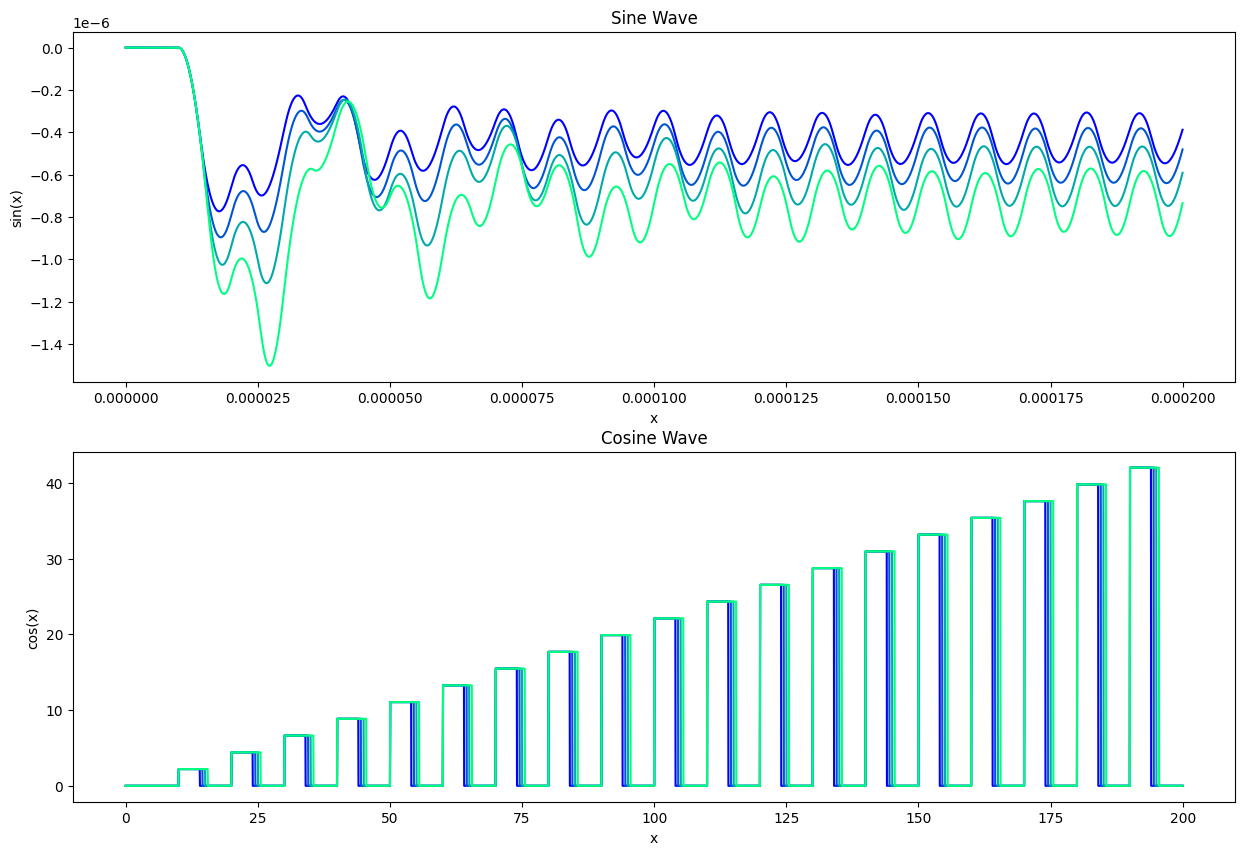

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import pi, sqrt

e0=8.85418782e-12
V=42
go = 3e-6
E=78e9 #Au
l = 300e-6
t = 0.8e-6
w = 100e-6
I=(w*(t)**3)/12
k2=3*E*I/(l**3)
k = 10 #k2 #10.0  # spring constant, N/m
m = 0.35*(w)*(l)*(t)*(19320) # mass, Kg
freq = 39.5e3 # change to (k/m)**0.5
C1 = 1e-80
C2 = 1e-75
A = w**2 #w*l*0.75
td=150e-9
er=7.6
y = 0.06e-6  # lambda

F = 55e-6 #restoring force???

time_list_empty = []
z_empty = []


fig, axs = plt.subplots(2, figsize=(15, 10))  # 2 subplots vertically

percent_list = [40, 45, 50, 55]#20, 25, 30, 35, 40, 45, 50]
color_idx = np.linspace(0, 1, len(percent_list))
for j, y in zip (color_idx, percent_list):
  time_list = []
  z = []
  state0_list = [[0,0]]

  percent = y
  TimePeriod = 10e-6
  Cycles = 20  # Single cycle
  dt = 10000
  Amplitude = 42
  num_steps = 1 * Cycles  # Number of amplitude steps across all cycles

  t = np.linspace(0, Cycles*TimePeriod, dt, endpoint=False)

  # Calculate the staircase amplitude over the entire duration
  total_time = Cycles * TimePeriod
  step_duration = total_time / num_steps
  current_step = np.floor(t / step_duration)
  oscillating_amplitude = (current_step / (num_steps - 1)) * Amplitude

  # Generate the PWM signal
  pwm = (t % TimePeriod < TimePeriod * y / 100) * oscillating_amplitude


  # Generate the PWM signal
  # Adjusting phase so it starts low
  #pwm = ((t % TimePeriod) >= (TimePeriod * y / 100)) * Amplitude

  # Define your functions for high and low states
  def process_segment(state, start, end):
      if state == 'High':
          # Example operation for high state
          #return f"High segment processed from {start:.8f} to {end:.8f} seconds"
          ###DOWN - VOLTAGE ON
          def rlc(state_yes,t_segment,Q):
              x, xd = state_yes
              g = x+go
              Fe = ((e0*A*(V**2))/((go+(td/er)+x)**2))*-0.5 #voltageSource
              Fc = ((C1*A)/(go+x)**3) - ((C2*A)/(go+x)**10)
              Qe = Q*((1.1-((x/go)**2))**(1.5))*(1+(9.638*((y/g)**1.159)))
              b = k/(2*pi*freq*Qe)   # damping coefficient - variable damping
              #b = k/(2*pi*freq*Q) # damping coefficient - constant damping
              ks = (55e-6-k*go)/(go**3)
              #F = k*(go-x) + ks*(go-x)**3
              xdd = (Fe+Fc-(b*xd)-(k*x)-(ks*(x**3)))/m
              return [xd, xdd]

          state0 = state0_list[-1]  #initial conditions [x0 , v0]  [m, m/sec]

          ti = start
          tf = end  # final time
          res = 10000 # steps
          t_segment = np.linspace(ti, tf, res)
          Q=2
          state_yes = odeint(rlc, state0, t_segment, args=(Q,))
          x = np.array(state_yes[:,[0]])
          xd = np.array(state_yes[:,[1]])
          #print(t_segment[-1], x[-1], xd[-1])
          state0_list.append([x[-1][0], xd[-1][0]])
          for i in range(len(x)):
              x[i] += go
          index = np.argmin(abs(x))
          #fig ,ax1 = plt.subplots()
          #ax1.plot(t[0:(index+1)]*1e6,x[0:(index+1)]*1e6, 'b-',linewidth=3) #x and y plotted values multiplied by 1e6 to scale up for plotted units.

          for i in t_segment:
            time_list.append(i)
          for i in state_yes[:,0]:
            z.append(i)

      elif state == 'Low':
          # Example operation for low state
          #return f"Low segment processed from {start:.8f} to {end:.8f} seconds"
          ###UP - VOLTAGE OFF

          def rlc(state_no,t_sement,Q):
              x, xd = state_no
              g =  go - x
              Qe = Q*((1.1-((x/go)**2))**(1.5))*(1+9.638*((y/g)**1.159))
              #b = k/(2*pi*freq*Qe)   # damping coefficient - variable damping
              b = k/(2*pi*freq*Q) # damping coefficient - constant damping
              ks = (F-k*go)/(go**3)
              Fc = ((C1*A)/(go-x)**3) - ((C2*A)/(go-x)**10)
              #F = k*(go-x) + ks*(go-x)**3
              xdd = (Fc-(b*xd)-k*x-ks*(x**3))/m
              return [xd, xdd]

          state0 = state0_list[-1] #[-1.85148446e-06, -0.39846986]   #initial conditions [x0 , v0]  [m, m/sec]

          ti = start
          tf = end  # final time
          res = 10000 # steps
          t_segment = np.linspace(ti, tf, res)

          Q=2

          state_no = odeint(rlc, state0, t_segment, args=(Q,))

          x = np.array(state_no[:,[0]])
          xd = np.array(state_no[:,[1]])

          #print(t_segment[-1], x[-1], xd[-1])
          state0_list.append([x[-1][0], xd[-1][0]])
          for i in range(len(x)):
              x[i] += go

          index = np.argmin(abs(x))

          #fig ,ax1 = plt.subplots()

          #ax1.plot(t1*1e6,x*1e6, 'r-',linewidth=3, label='$Q = 0.5$')
          #ax1.plot(t*1e6,x*1e6, 'b-',linewidth=3) #x and y plotted values multiplied by 1e6 to scale up for plotted units.

          #ax1.set_xlabel('time ($\mu$s)')
          #ax1.set_ylabel('Gap Height ($\mu$m)', )#color='g')

          for i in t_segment:
            time_list.append(i)
          for i in state_no[:,0]:
            z.append(i)



  # Initialize variables to store the start times for high and low states
  start_high = None
  start_low = None
  # Initialize lists to store start and end times for high and low states, including state information
  segments = []

  # Handle the initial state
  if pwm[0] > 0:
      start_high = t[0]
  else:
      start_low = t[0]

  # Identify segments
  for i in range(1, len(pwm)):
      if pwm[i] != pwm[i-1]:  # State change
          if pwm[i] > 0:  # Transition to high
              start_high = t[i]
              if start_low is not None:
                  end_low = t[i-1]
                  segments.append(('Low', start_low, end_low))
                  start_low = None
          else:  # Transition from high to low
              end_high = t[i-1]
              if start_high is not None:
                  segments.append(('High', start_high, end_high))
                  start_high = None
              start_low = t[i]

  # Ensure the last segment is captured
  if start_high is not None:
      segments.append(('High', start_high, t[-1]))
  elif start_low is not None:
      segments.append(('Low', start_low, t[-1]))

  # Sort segments by their start time
  segments.sort(key=lambda x: x[1])

  # Process each segment in order
  for segment in segments:
      state, start, end = segment
      process_segment(state, start, end)

  time_list_empty.append(time_list)
  z_empty.append(z)
  # Plot the original signal for reference
  col=plt.cm.winter(j)

  # Create a figure and a set of subplots


  # Plotting on the first subplot
  axs[0].plot(time_list, z, color=col)  # 'b' specifies the color blue
  axs[0].set_title('Sine Wave')
  axs[0].set_xlabel('x')
  axs[0].set_ylabel('sin(x)')

  # Plotting on the second subplot
  axs[1].plot(t*1e6, pwm, color=col)  # 'r' specifies the color red
  axs[1].set_title('Cosine Wave')
  axs[1].set_xlabel('x')
  axs[1].set_ylabel('cos(x)')

  '''
  plt.figure(1, figsize=(10, 4))
  #plt.plot(t, pwm)
  plt.plot(time_list,z, color=col)
  plt.title('Original Signal')
  #plt.show()
  '''
plt.show()

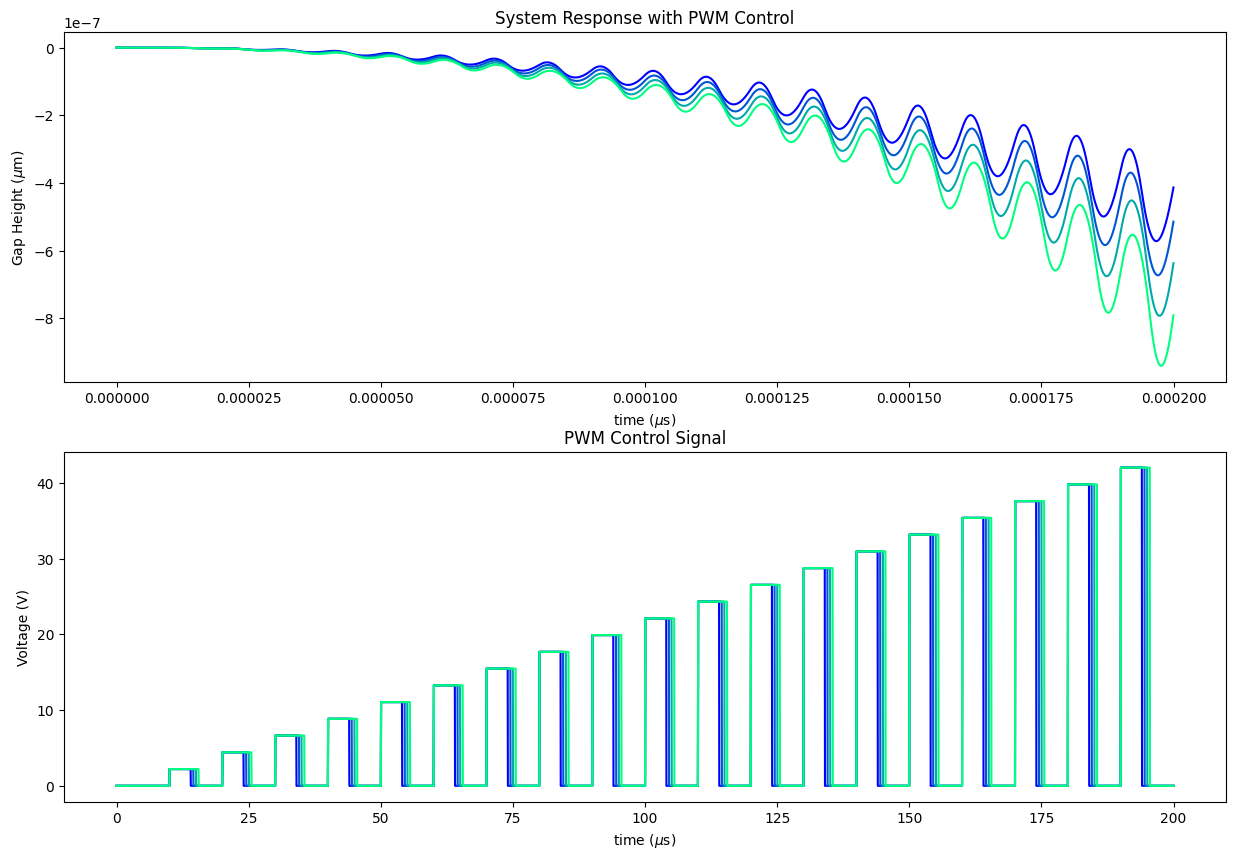

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import pi, sqrt

e0=8.85418782e-12
V=42
go = 3e-6
E=78e9 #Au
l = 300e-6
t = 0.8e-6
w = 100e-6
I=(w*(t)**3)/12
k2=3*E*I/(l**3)
k = 10 #k2 #10.0  # spring constant, N/m
m = 0.35*(w)*(l)*(t)*(19320) # mass, Kg
freq = 39.5e3 # change to (k/m)**0.5
C1 = 1e-80
C2 = 1e-75
A = w**2 #w*l*0.75
td=150e-9
er=7.6
y = 0.06e-6  # lambda
F = 55e-6 #restoring force???

time_list_empty = []
z_empty = []

fig, axs = plt.subplots(2, figsize=(15, 10))  # 2 subplots vertically

percent_list = [40, 45, 50, 55]#20, 25, 30, 35, 40, 45, 50]
color_idx = np.linspace(0, 1, len(percent_list))
for j, y in zip (color_idx, percent_list):
  time_list = []
  z = []
  state0_list = [[0,0]]

  percent = y
  TimePeriod = 10e-6
  Cycles = 20  # Single cycle
  dt = 10000
  Amplitude = 42
  num_steps = 1 * Cycles  # Number of amplitude steps across all cycles
  t = np.linspace(0, Cycles*TimePeriod, dt, endpoint=False)
  # Calculate the staircase amplitude over the entire duration
  total_time = Cycles * TimePeriod
  step_duration = total_time / num_steps
  current_step = np.floor(t / step_duration)
  oscillating_amplitude = (current_step / (num_steps - 1)) * Amplitude
  # Generate the PWM signal
  pwm = (t % TimePeriod < TimePeriod * y / 100) * oscillating_amplitude

  # Define your functions for high and low states
  def process_segment(state, start, end, V):
      if state == 'High':
          def rlc(state_yes,t_segment,Q):
              x, xd = state_yes
              g = x+go
              Fe = ((e0*A*(V**2))/((go+(td/er)+x)**2))*-0.5 #voltageSource
              Fc = ((C1*A)/(go+x)**3) - ((C2*A)/(go+x)**10)
              Qe = Q*((1.1-((x/go)**2))**(1.5))*(1+(9.638*((y/g)**1.159)))
              b = k/(2*pi*freq*Qe)   # damping coefficient - variable damping
              #b = k/(2*pi*freq*Q) # damping coefficient - constant damping
              ks = (55e-6-k*go)/(go**3)
              #F = k*(go-x) + ks*(go-x)**3
              xdd = (Fe+Fc-(b*xd)-(k*x)-(ks*(x**3)))/m
              return [xd, xdd]

          state0 = state0_list[-1]  #initial conditions [x0 , v0]  [m, m/sec]
          t_segment = np.linspace(start, end, 10000)
          Q=2
          state_yes = odeint(rlc, state0, t_segment, args=(Q,))
          x = np.array(state_yes[:,[0]])
          xd = np.array(state_yes[:,[1]])
          #print(t_segment[-1], x[-1], xd[-1])
          state0_list.append([x[-1][0], xd[-1][0]])
          for i in range(len(x)):
              x[i] += go
          index = np.argmin(abs(x))
          for i in t_segment:
            time_list.append(i)
          for i in state_yes[:,0]:
            z.append(i)

      elif state == 'Low':
          def rlc(state_no,t_sement,Q):
              x, xd = state_no
              g =  go - x
              Qe = Q*((1.1-((x/go)**2))**(1.5))*(1+9.638*((y/g)**1.159))
              #b = k/(2*pi*freq*Qe)   # damping coefficient - variable damping
              b = k/(2*pi*freq*Q) # damping coefficient - constant damping
              ks = (F-k*go)/(go**3)
              Fc = ((C1*A)/(go-x)**3) - ((C2*A)/(go-x)**10)
              #F = k*(go-x) + ks*(go-x)**3
              xdd = (Fc-(b*xd)-k*x-ks*(x**3))/m
              return [xd, xdd]

          state0 = state0_list[-1] #conditions [x0 , v0]  [m, m/sec]
          t_segment = np.linspace(start, end, 10000)
          Q=2
          state_no = odeint(rlc, state0, t_segment, args=(Q,))
          x = np.array(state_no[:,[0]])
          xd = np.array(state_no[:,[1]])
          #print(t_segment[-1], x[-1], xd[-1])
          state0_list.append([x[-1][0], xd[-1][0]])
          for i in range(len(x)):
              x[i] += go
          index = np.argmin(abs(x))
          for i in t_segment:
            time_list.append(i)
          for i in state_no[:,0]:
            z.append(i)

  # Initialize variables to store the start times for high and low states
  start_high = None
  start_low = None
  # Initialize lists to store start and end times for high and low states, including state information
  segments = []

  # Handle the initial state
  if pwm[0] > 0:
      start_high = t[0]
  else:
      start_low = t[0]

  # Identify segments
  for i in range(1, len(pwm)):
      if pwm[i] != pwm[i-1]:  # State change
          if pwm[i] > 0:  # Transition to high
              start_high = t[i]
              if start_low is not None:
                  end_low = t[i-1]
                  segments.append(('Low', start_low, end_low))
                  start_low = None
          else:  # Transition from high to low
              end_high = t[i-1]
              if start_high is not None:
                  segments.append(('High', start_high, end_high))
                  start_high = None
              start_low = t[i]

  # Ensure the last segment is captured
  if start_high is not None:
      segments.append(('High', start_high, t[-1]))
  elif start_low is not None:
      segments.append(('Low', start_low, t[-1]))

  # Sort segments by their start time
  segments.sort(key=lambda x: x[1])

  # Process each segment in order
  for segment in segments:
      state, start, end = segment
      V = max(pwm[(t >= start) & (t <= end)])  # Get max amplitude for this segment
      process_segment(state, start, end, V)

  time_list_empty.append(time_list)
  z_empty.append(z)
  # Plot the original signal for reference
  col=plt.cm.winter(j)
  # Plotting on the first subplot
  axs[0].plot(time_list, z, color=col)  # 'b' specifies the color blue
  axs[0].set_title('System Response with PWM Control')
  axs[0].set_xlabel('time ($\mu$s)')
  axs[0].set_ylabel('Gap Height ($\mu$m)')

  # Plotting on the second subplot
  axs[1].plot(t*1e6, pwm, color=col)  # 'r' specifies the color red
  axs[1].set_title('PWM Control Signal')
  axs[1].set_xlabel('time ($\mu$s)')
  axs[1].set_ylabel('Voltage (V)')

plt.show()

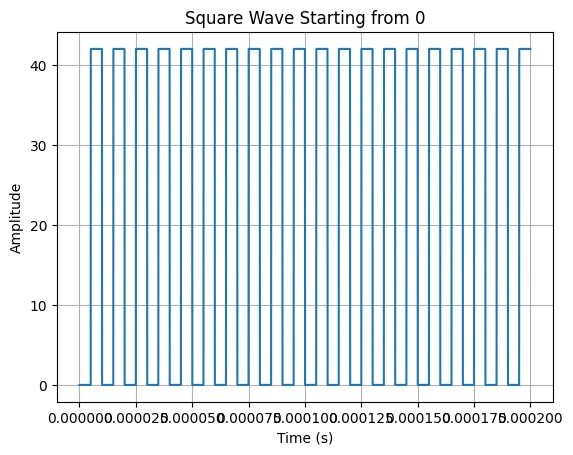

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
y = 50  # Duty cycle percentage (50% for a typical square wave)
TimePeriod = 10e-6
Cycles = 20  # Number of cycles
dt = 10000
Amplitude = 42

# Time array
t = np.linspace(0, Cycles * TimePeriod, dt, endpoint=False)

# Generate the PWM signal
# Adjusting phase so it starts low
pwm = ((t % TimePeriod) >= (TimePeriod * y / 100)) * Amplitude

# Plotting
plt.plot(t, pwm)
plt.title('Square Wave Starting from 0')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



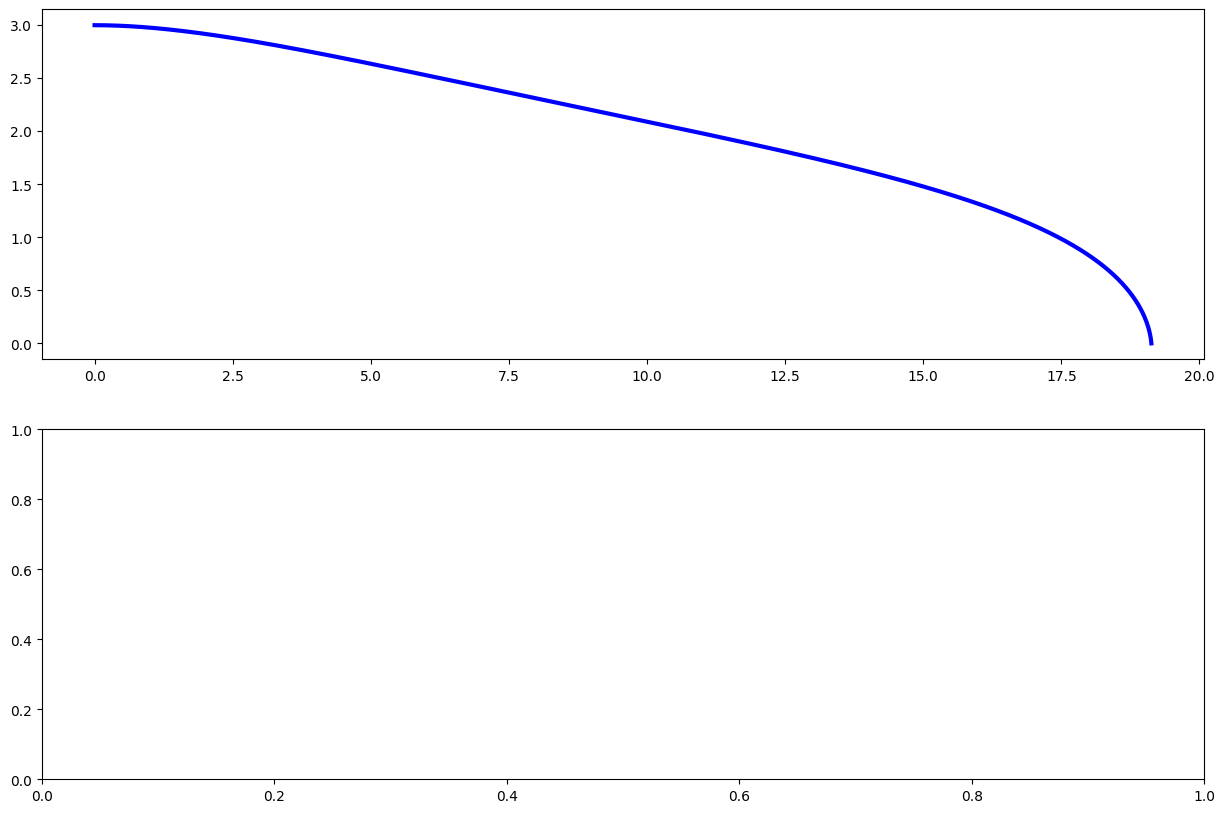

In [ ]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy import pi, sqrt

e0=8.85418782e-12
V=42
go = 3e-6
E=78e9 #Au
l = 300e-6
t = 0.8e-6
w = 100e-6
I=(w*(t)**3)/12
k2=3*E*I/(l**3)
k = 10 #k2 #10.0  # spring constant, N/m
m = 0.35*(w)*(l)*(t)*(19320) # mass, Kg
freq = 39.5e3 # change to (k/m)**0.5
C1 = 1e-80
C2 = 1e-75
A = w**2 #w*l*0.75
td=150e-9
er=7.6
y = 0.06e-6  # lambda
F = 55e-6 #restoring force???

def rlc(state,t,Q):
    x, xd = state
    g = x+go
    Fe = ((e0*A*(V**2))/((go+(td/er)+x)**2))*-0.5 #voltageSource
    Fc = ((C1*A)/((go+x)**3)) - ((C2*A)/((go+x)**10))
    Qe = Q*((1.1-((x/go)**2))**(1.5))*(1+(9.638*((y/g)**1.159)))
    b = k/(2*pi*freq*Qe)   # damping coefficient - variable damping
    #b = k/(2*pi*freq*Q) # damping coefficient - constant damping
    ks = (55e-6-k*go)/(go**3)
    #F = k*(go-x) + ks*(go-x)**3
    xdd = (Fe+Fc-(b*xd)-(k*x)-(ks*(x**3)))/m
    return [xd, xdd]

state0 = [0.0, 0.0]  #initial conditions [x0 , v0]  [m, m/sec]

ti = 0.0  # initial time
tf = 40e-6  # final time
res = 10000 # steps
t = np.linspace(ti, tf, res)

Q=0.5

state = odeint(rlc, state0, t, args=(Q,))

x = np.array(state[:,[0]])
xd = np.array(state[:,[1]])

for i in range(len(x)):
    x[i] += go

index = np.argmin(abs(x))

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

axs[0].plot(t[0:(index+1)]*1e6,x[0:(index+1)]*1e6, 'b-',linewidth=3) #x and y plotted values multiplied by 1e6 to scale up for plotted units.

#plt.ylim(0,1.2)
#plt.xlim(0,3)

#ax1.tick_params(axis='y', labelcolor='g')

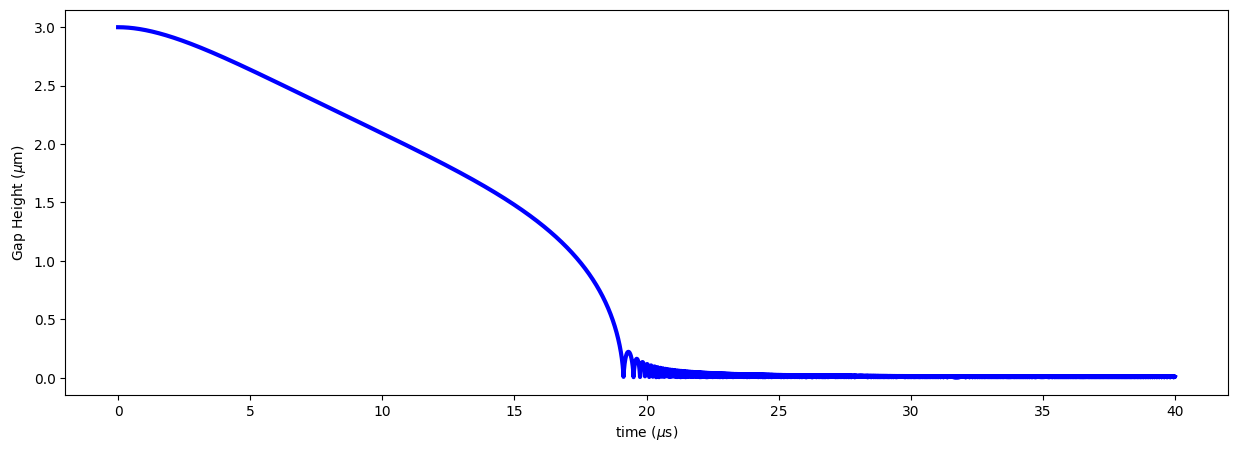

In [ ]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy import pi, sqrt

e0=8.85418782e-12
V=42
go = 3e-6
E=78e9 #Au
l = 300e-6
t = 0.8e-6
w = 100e-6
I=(w*(t)**3)/12
k2=3*E*I/(l**3)
k = 10 #k2 #10.0  # spring constant, N/m
m = 0.35*(w)*(l)*(t)*(19320) # mass, Kg
freq = 39.5e3 # change to (k/m)**0.5
C1 = 1e-80
C2 = 1e-75
A = w**2 #w*l*0.75
td=150e-9
er=7.6
y = 0.06e-6  # lambda
F = 55e-6 #restoring force???

def rlc(state, t, Q):
    x, xd = state
    g = x + go

    # Protect against negative gap in a physical sense
    if x < -go:  # Ensuring gap does not go negative
        x = -go
        xd = -xd * 0.5  # Rebound with damping effect

    Fe = ((e0 * A * (V ** 2)) / ((go + (td / er) + x) ** 2)) * -0.5  # Attractive electrostatic force
    # Repulsive force adjustment
    Fc = -((C1 * A) / ((go + x) ** 3)) + ((C2 * A) / ((go + x) ** 10))
    Qe = Q * ((1.1 - ((x / go) ** 2)) ** (1.5)) * (1 + (9.638 * ((y / (g if g != 0 else 1e-9)) ** 1.159)))
    b = k / (2 * pi * freq * Qe)  # Damping based on quality factor
    ks = (55e-6 - k * go) / (go ** 3)  # Additional non-linear spring behavior

    # Force balance including mechanical spring and non-linear components
    xdd = (Fe + Fc - (b * xd) - (k * x) - (ks * (x ** 3))) / m
    return [xd, xdd]

state0 = [0.0, 0.0]  # Initial conditions [displacement, velocity]

ti = 0.0
tf = 40e-6
res = 10000
t = np.linspace(ti, tf, res)

Q = 0.5

state = odeint(rlc, state0, t, args=(Q,))

x = np.array(state[:, 0]) + go
xd = np.array(state[:, 1])

fig, ax1 = plt.subplots(figsize = (15,5))

ax1.plot(t * 1e6, x * 1e6, 'b-', linewidth=3)
ax1.set_xlabel('time ($\mu$s)')
ax1.set_ylabel('Gap Height ($\mu$m)')
#ax1.set_xlim(19, 21)
plt.show()


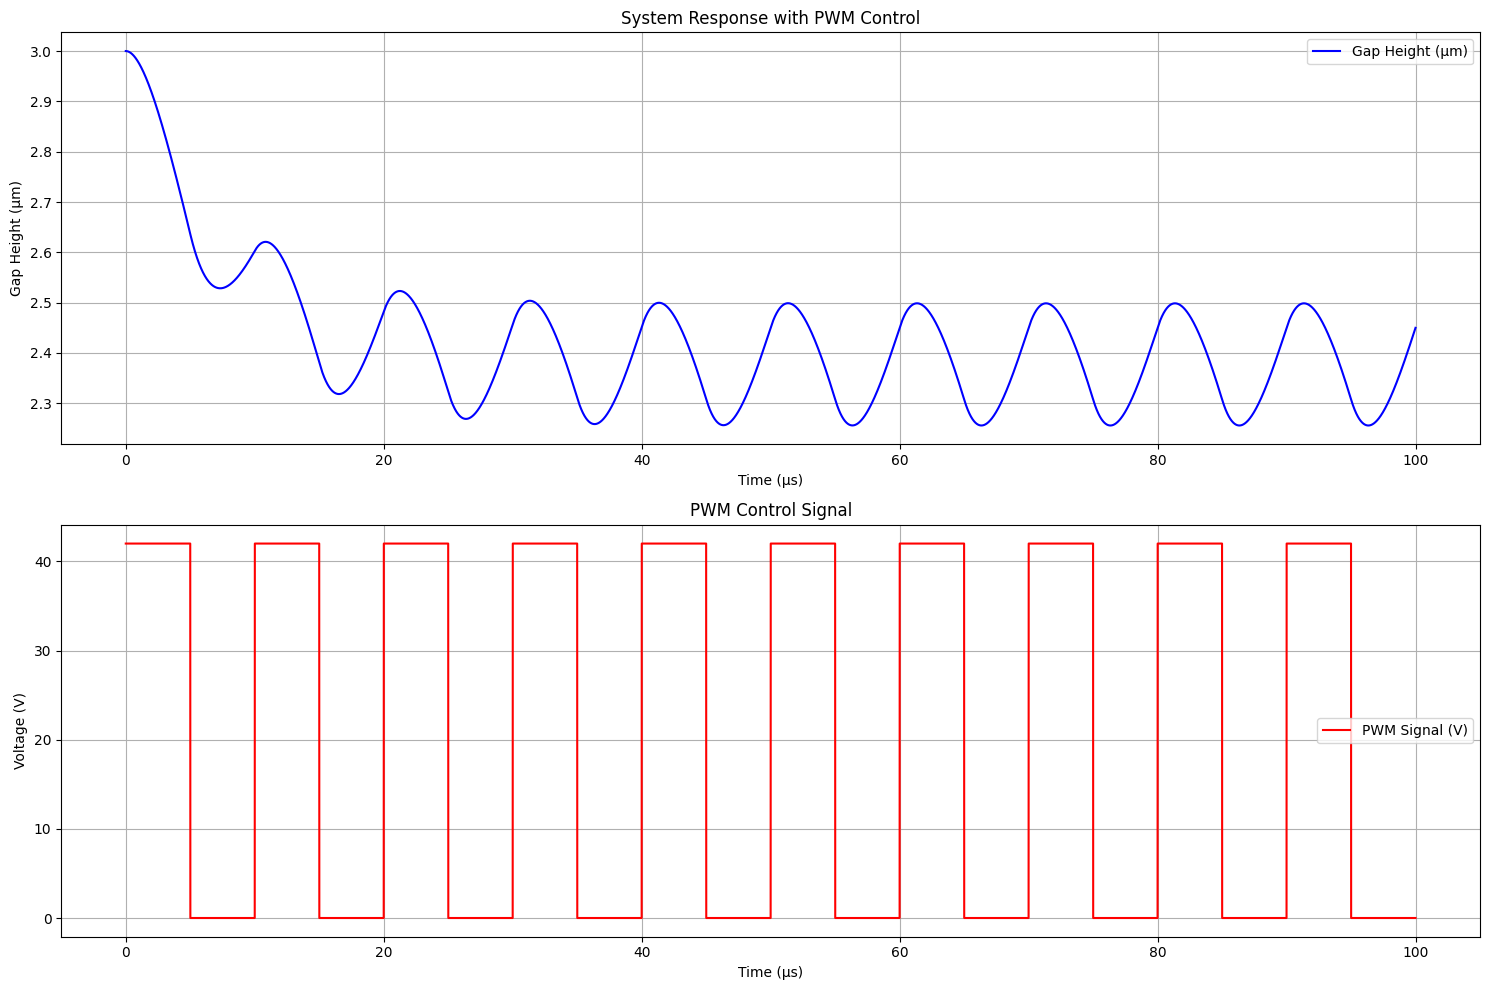

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import pi

# Constants
e0 = 8.85418782e-12  # Permittivity of free space
V = 42               # Voltage (peak voltage for PWM)
go = 3e-6            # Initial gap
E = 78e9             # Young's modulus for Au
l = 300e-6           # Length
t = 0.8e-6           # Thickness
w = 100e-6           # Width
I = (w * t**3) / 12  # Moment of inertia
k = 10               # Spring constant, N/m
m = 0.35 * w * l * t * 19320  # Mass, Kg
freq = 39.5e3        # Frequency
C1 = 1e-80           # Coefficient for repulsive force
C2 = 1e-75           # Coefficient for repulsive force
A = w**2             # Area
td = 150e-9          # Some distance
er = 7.6             # Relative permittivity
y = 0.06e-6          # Some constant, lambda
F = 55e-6            # Restoring force

def voltage_control(t, period=10e-6, duty_cycle=0.5):
    """ Generate a square wave voltage signal. """
    return V if (t % period) < (period * duty_cycle) else 0

def rlc(state, t, Q):
    x, xd = state
    g = x + go
    current_voltage = voltage_control(t)  # Get voltage based on the control function

    if x < -go:  # Prevent negative gap
        x = -go
        xd = -xd * 0.5  # Damping effect on rebound

    Fe = ((e0 * A * (current_voltage ** 2)) / ((go + (td / er) + x) ** 2)) * -0.5
    Fc = -((C1 * A) / (go + x) ** 3) + ((C2 * A) / (go + x) ** 10)
    Qe = Q * ((1.1 - ((x / go) ** 2)) ** (1.5)) * (1 + (9.638 * ((y / (g if g != 0 else 1e-9)) ** 1.159)))
    b = k / (2 * pi * freq * Qe)
    ks = (F - k * go) / (go ** 3)

    xdd = (Fe + Fc - (b * xd) - (k * x) - (ks * (x ** 3))) / m
    return [xd, xdd]

# Simulation setup
state0 = [0.0, 0.0]  # Initial conditions
total_time = 100e-6  # Total simulation time, 100 microseconds
res = 100000  # High resolution for better PWM representation
t = np.linspace(0, total_time, res)
Q = 0.5

# Generate PWM signal for plotting
pwm_signal = np.array([voltage_control(ti) for ti in t])

# Run simulation
state = odeint(rlc, state0, t, args=(Q,))

x = np.array(state[:, 0]) + go
xd = np.array(state[:, 1])

# Plotting results
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(t * 1e6, x * 1e6, 'b-', label='Gap Height (µm)')
axs[0].set_xlabel('Time (µs)')
axs[0].set_ylabel('Gap Height (µm)')
axs[0].set_title('System Response with PWM Control')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(t * 1e6, pwm_signal, 'r-', label='PWM Signal (V)')
axs[1].set_xlabel('Time (µs)')
axs[1].set_ylabel('Voltage (V)')
axs[1].set_title('PWM Control Signal')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

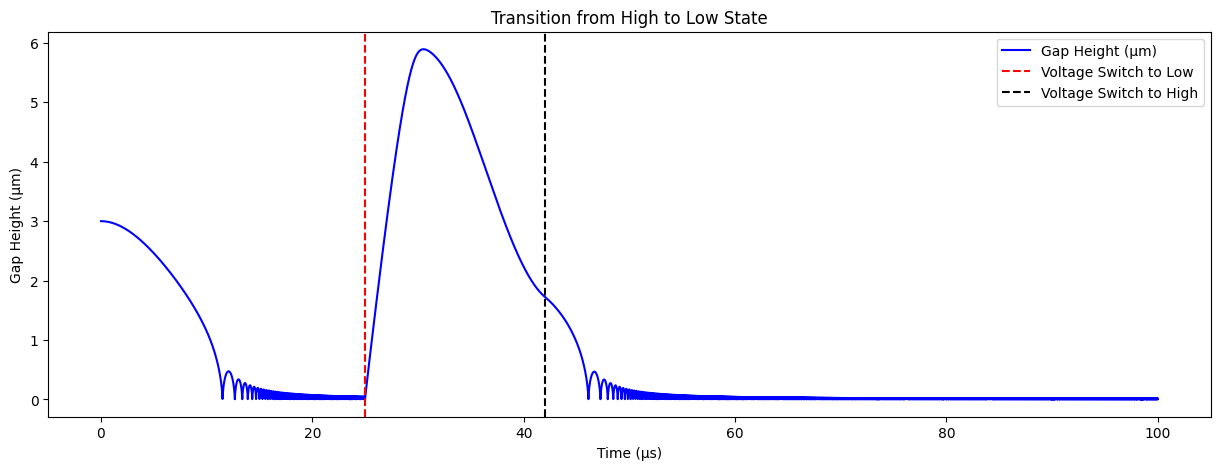

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import pi

# Constants
e0 = 8.85418782e-12  # Permittivity of free space
V = 42               # Voltage
go = 3e-6            # Initial gap
E = 78e9             # Young's modulus for Au
l = 300e-6           # Length
t = 0.8e-6           # Thickness
w = 100e-6           # Width
I = (w * t**3) / 12  # Moment of inertia
k = 10               # Spring constant, N/m
m = 0.35 * w * l * t * 19320  # Mass, Kg
freq = 39.5e3        # Frequency
C1 = 1e-80           # Coefficient for repulsive force
C2 = 1e-75           # Coefficient for repulsive force
A = w**2             # Area
td = 150e-9          # Some distance
er = 7.6             # Relative permittivity
y = 0.06e-6          # Some constant, lambda
F = 55e-6            # Restoring force

def rlc(state, t, Q):
    x, xd = state
    g = x + go
    # Decide voltage based on time
    voltage = V if t < 25e-6 or t > 42e-6 else 0  # Apply voltage for the first 25 microseconds

    if x < -go:  # Prevent negative gap
        x = -go
        #xd = -xd * 0.5  # Damping effect on rebound

    Fe = ((e0 * A * (voltage ** 2)) / ((go + (td / er) + x) ** 2)) * -0.5
    Fc = -((C1 * A) / (go + x) ** 3) + ((C2 * A) / (go + x) ** 10)
    Qe = Q * ((1.1 - ((x / go) ** 2)) ** (1.5)) * (1 + (9.638 * ((y / (g if g != 0 else 1e-9)) ** 1.159)))
    b = k / (2 * pi * freq * Qe)  # Damping based on quality factor
    ks = (F - k * go) / (go ** 3)  # Non-linear spring behavior

    xdd = (Fe + Fc - (b * xd) - (k * x) - (ks * (x ** 3))) / m
    return [xd, xdd]

# Simulation setup
state0 = [0.0, 0.0]  # Initial conditions
total_time = 100e-6  # Total simulation time, 50 microseconds
res = 50000  # Increased resolution for smoother transition
t = np.linspace(0, total_time, res)
Q = 2

# Run simulation
state = odeint(rlc, state0, t, args=(Q,))

x = np.array(state[:, 0]) + go
xd = np.array(state[:, 1])

# Plotting results
plt.figure(figsize=(15, 5))
plt.plot(t * 1e6, x * 1e6, 'b-', label='Gap Height (µm)')
plt.axvline(25, color='r', linestyle='--', label='Voltage Switch to Low')
plt.axvline(42, color='k', linestyle='--', label='Voltage Switch to High')
plt.xlabel('Time (µs)')
plt.ylabel('Gap Height (µm)')
plt.title('Transition from High to Low State')
plt.legend()
plt.show()

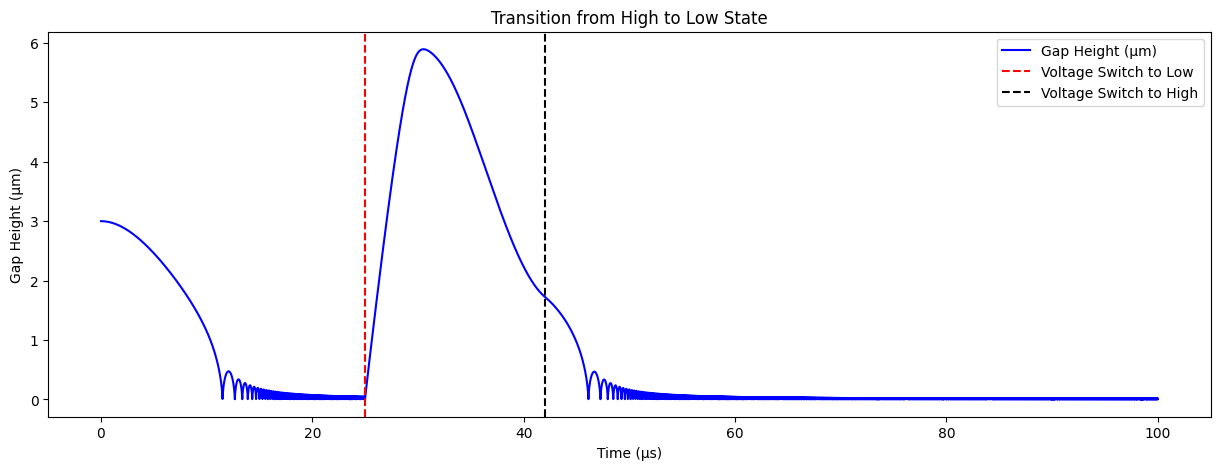

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import pi

# Constants
e0 = 8.85418782e-12  # Permittivity of free space
V = 42               # Voltage
go = 3e-6            # Initial gap
E = 78e9             # Young's modulus for Au
l = 300e-6           # Length
t = 0.8e-6           # Thickness
w = 100e-6           # Width
I = (w * t**3) / 12  # Moment of inertia
k = 10               # Spring constant, N/m
m = 0.35 * w * l * t * 19320  # Mass, Kg
freq = 39.5e3        # Frequency
C1 = 1e-80           # Coefficient for repulsive force
C2 = 1e-75           # Coefficient for repulsive force
A = w**2             # Area
td = 150e-9          # Some distance
er = 7.6             # Relative permittivity
y = 0.06e-6          # Some constant, lambda
F = 55e-6            # Restoring force

def rlc(state, t, Q):
    x, xd = state
    g = x + go
    # Decide voltage based on time
    voltage = V if t < 25e-6 or t > 42e-6 else 0  # Apply voltage for the first 25 microseconds

    if x < -go:  # Prevent negative gap
        x = -go
        xd = -xd * 0.5  # Damping effect on rebound

    Fe = ((e0 * A * (voltage ** 2)) / ((go + (td / er) + x) ** 2)) * -0.5
    Fc = -((C1 * A) / (go + x) ** 3) + ((C2 * A) / (go + x) ** 10)
    Qe = Q * ((1.1 - ((x / go) ** 2)) ** (1.5)) * (1 + (9.638 * ((y / (g if g != 0 else 1e-9)) ** 1.159)))
    b = k / (2 * pi * freq * Qe)  # Damping based on quality factor
    ks = (F - k * go) / (go ** 3)  # Non-linear spring behavior

    xdd = (Fe + Fc - (b * xd) - (k * x) - (ks * (x ** 3))) / m
    return [xd, xdd]

# Simulation setup
state0 = [0.0, 0.0]  # Initial conditions
total_time = 100e-6  # Total simulation time, 50 microseconds
res = 50000  # Increased resolution for smoother transition
t = np.linspace(0, total_time, res)
Q = 2

# Run simulation
state = odeint(rlc, state0, t, args=(Q,))

x = np.array(state[:, 0]) + go
xd = np.array(state[:, 1])

# Plotting results
plt.figure(figsize=(15, 5))
plt.plot(t * 1e6, x * 1e6, 'b-', label='Gap Height (µm)')
plt.axvline(25, color='r', linestyle='--', label='Voltage Switch to Low')
plt.axvline(42, color='k', linestyle='--', label='Voltage Switch to High')
plt.xlabel('Time (µs)')
plt.ylabel('Gap Height (µm)')
plt.title('Transition from High to Low State')
plt.legend()
plt.show()